In [18]:
# Importando pacotes necessários
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


In [6]:
# Carregar o arquivo 'dados.csv' no dataframe
df = pd.read_csv('dados.csv')

# Exibir as primeiras linhas do dataframe para verificar se foi carregado corretamente
# print(df.head())

Aplicando o PCA

In [7]:
# Separar as variáveis independentes (X) e a variável dependente (y)
dadosPCA = df.drop('CLASSE', axis=1)
classe_1 = df['CLASSE']

In [10]:
# Padronizar os dados antes de aplicar o PCA
scaler = StandardScaler()
dadosPCA_scaled = scaler.fit_transform(dadosPCA)

In [13]:
# Aplicar PCA
pca = PCA()
dadosPCA_reduced = pca.fit_transform(dadosPCA_scaled)

In [14]:
# Variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

In [15]:
# Variância acumulada
cumulative_variance = np.cumsum(explained_variance)


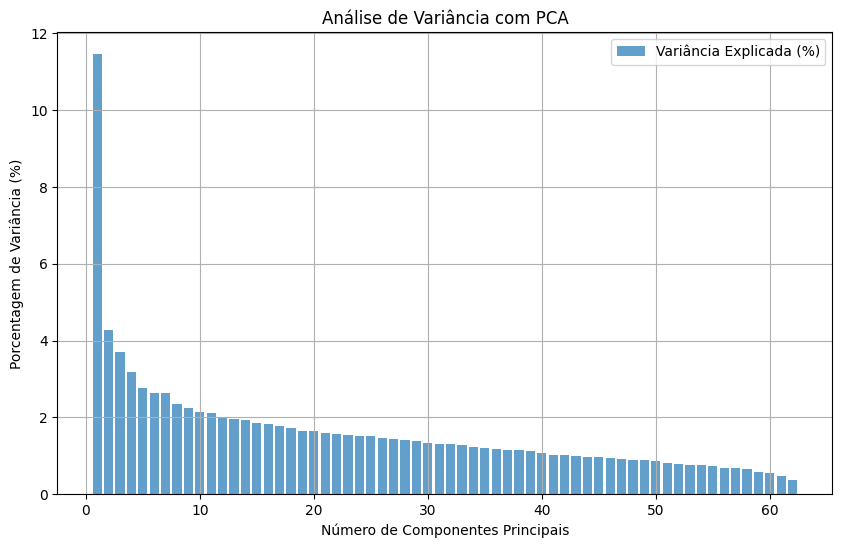

In [24]:
# Plotar a variância explicada e a acumulada em gráficos de barras
plt.figure(figsize=(10, 6))

# Gráfico de barras para a variância explicada
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Variância Explicada (%)')
plt.title('Análise de Variância com PCA')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Porcentagem de Variância (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()
